<a href="https://colab.research.google.com/github/SapirBashan/radar_animation/blob/main/visualie_radar.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Constants
C = 3e8  # Speed of light (m/s)
fc = 77e9  # Carrier frequency (Hz)
bandwidth = 150e6  # Bandwidth (Hz)
range_resolution = C / (2 * bandwidth)
max_range = 200  # Max range (meters)
chirp_duration = 1e-6  # Chirp duration (seconds)
sampling_rate = 2 * bandwidth  # Sampling rate (Hz)

# Derived parameters
num_samples = int(chirp_duration * sampling_rate)
ranges = np.linspace(0, max_range, num_samples)

# Simulated parameters
num_chirps = 128  # Number of chirps in a frame
target_range = 50  # Target distance (meters)
target_velocity = 30  # Target velocity (m/s)
snr_db = 20  # Signal-to-noise ratio (dB)

# Step 1: Transmit Signal
def transmit_signal():
    t = np.linspace(0, chirp_duration, num_samples, endpoint=False)
    return np.exp(1j * 2 * np.pi * fc * t)  # Simple chirp waveform

# Step 2: Receive Signal (Simulated)
def receive_signal(tx_signal, ranges, velocity, snr_db):
    t = np.linspace(0, chirp_duration, num_samples, endpoint=False)
    range_delay = 2 * target_range / C
    doppler_shift = 2 * fc * (target_velocity / C)
    received_signal = tx_signal * np.exp(1j * 2 * np.pi * doppler_shift * t) * np.exp(-1j * 2 * np.pi * fc * range_delay)
    noise = np.random.normal(0, 1, num_samples) + 1j * np.random.normal(0, 1, num_samples)
    signal_power = np.mean(np.abs(received_signal)**2)
    noise_power = signal_power / (10**(snr_db / 10))
    noise = noise * np.sqrt(noise_power)
    return received_signal + noise

# Step 3: Pulse Compression
def pulse_compression(rx_signal, tx_signal):
    return np.correlate(rx_signal, tx_signal, mode='same')

# Step 4: Range Processing (1D FFT)
def range_fft(pulse_compressed_signal):
    return np.fft.fftshift(np.fft.fft(pulse_compressed_signal))

# Step 5: Doppler Processing (2D FFT)
def doppler_processing(range_data, num_chirps):
    # Calculate the appropriate number of columns to maintain the total number of elements
    num_cols = len(range_data) // num_chirps

    # Reshape the range data to a 2D array before applying 2D FFT, using only the relevant data
    range_data_2d = range_data[:num_chirps * num_cols].reshape(num_chirps, num_cols)

    range_doppler_map = np.fft.fftshift(np.fft.fft2(range_data_2d), axes=(0, 1))  # Apply 2D FFT
    return np.abs(range_doppler_map)

# Step 6: Detection (CFAR)
def cfar(range_doppler_map, num_guard_cells=2, num_training_cells=10, threshold_factor=1.5):
    detected_targets = np.zeros_like(range_doppler_map)
    num_rows, num_cols = range_doppler_map.shape
    for i in range(num_training_cells + num_guard_cells, num_rows - num_training_cells - num_guard_cells):
        for j in range(num_training_cells + num_guard_cells, num_cols - num_training_cells - num_guard_cells):
            training_cells = range_doppler_map[
                i - num_training_cells - num_guard_cells : i + num_training_cells + num_guard_cells + 1,
                j - num_training_cells - num_guard_cells : j + num_training_cells + num_guard_cells + 1,
            ]
            guard_cells = range_doppler_map[
                i - num_guard_cells : i + num_guard_cells + 1,
                j - num_guard_cells : j + num_guard_cells + 1,
            ]
            noise_level = np.mean(training_cells) - np.mean(guard_cells)
            if range_doppler_map[i, j] > threshold_factor * noise_level:
                detected_targets[i, j] = 1
    return detected_targets


In [ ]:
# Simulating the radar pipeline
tx_signal = transmit_signal()
rx_signal = receive_signal(tx_signal, target_range, target_velocity, snr_db)
pulse_compressed = pulse_compression(rx_signal, tx_signal)
range_data = range_fft(pulse_compressed)
range_doppler_map = doppler_processing(range_data, num_chirps)

# Detection
detected_targets = cfar(range_doppler_map)

In [ ]:

# Visualization
plt.figure(figsize=(12, 6))

<Figure size 1200x600 with 0 Axes>

<Figure size 1200x600 with 0 Axes>

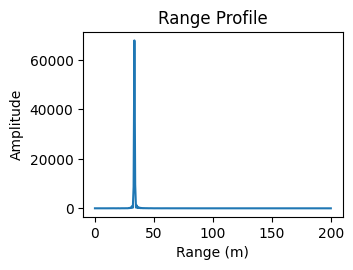

In [ ]:
# Range Profile
plt.subplot(2, 2, 1)
plt.plot(ranges, np.abs(range_data))
plt.title("Range Profile")
plt.xlabel("Range (m)")
plt.ylabel("Amplitude")
plt.tight_layout()
plt.show()

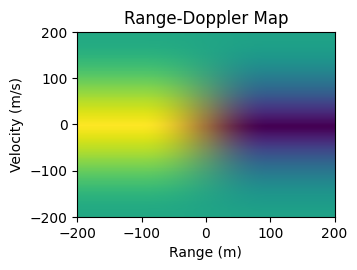

In [ ]:
# Doppler Map
plt.subplot(2, 2, 2)
plt.imshow(np.log10(range_doppler_map + 1e-6), extent=[-max_range, max_range, -max_range, max_range], aspect='auto')
plt.title("Range-Doppler Map")
plt.xlabel("Range (m)")
plt.ylabel("Velocity (m/s)")
plt.tight_layout()
plt.show()

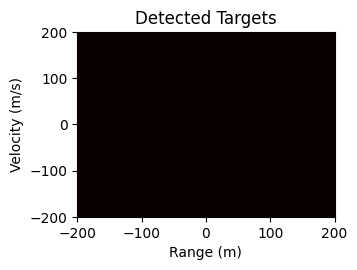

In [ ]:
# Detected Targets
plt.subplot(2, 2, 3)
plt.imshow(detected_targets, extent=[-max_range, max_range, -max_range, max_range], aspect='auto', cmap="hot")
plt.title("Detected Targets")
plt.xlabel("Range (m)")
plt.ylabel("Velocity (m/s)")
plt.tight_layout()
plt.show()

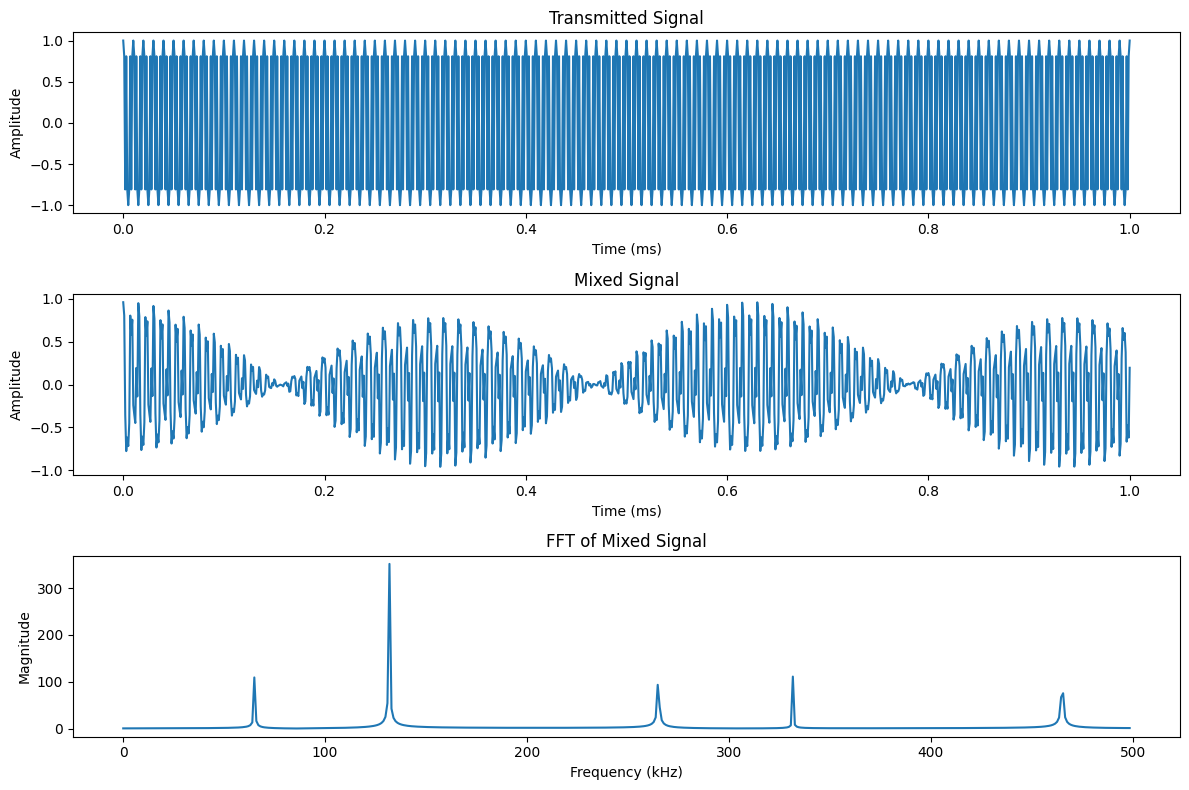

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import chirp
from scipy.fft import fft

# Radar parameters
c = 3e8  # Speed of light
f0 = 24e9  # Start frequency (24 GHz)
B = 200e6  # Bandwidth
T = 1e-3  # Chirp duration
fs = 1e6  # Sampling frequency

# Target parameters
R = 100  # Range (m)
v = 10  # Velocity (m/s)

# Time array
t = np.arange(0, T, 1/fs)

# Generate chirp signal
tx_signal = chirp(t, f0, T, f0+B, method='linear')

# Simulate received signal
tau = 2*R/c  # Time delay
fd = 2*v*f0/c  # Doppler shift
rx_signal = chirp(t-tau, f0, T, f0+B, method='linear') * np.exp(1j*2*np.pi*fd*t)

# Mix transmitted and received signals
mixed_signal = tx_signal * rx_signal.conj()

# Perform FFT
fft_signal = fft(mixed_signal)
fft_signal = fft_signal[:len(fft_signal)//2]  # Keep positive frequencies

# Calculate frequency axis
freq = np.fft.fftfreq(len(t), 1/fs)[:len(t)//2]

# Plot results
plt.figure(figsize=(12, 8))

plt.subplot(3, 1, 1)
plt.plot(t*1e3, tx_signal.real)
plt.title('Transmitted Signal')
plt.xlabel('Time (ms)')
plt.ylabel('Amplitude')

plt.subplot(3, 1, 2)
plt.plot(t*1e3, mixed_signal.real)
plt.title('Mixed Signal')
plt.xlabel('Time (ms)')
plt.ylabel('Amplitude')

plt.subplot(3, 1, 3)
plt.plot(freq/1e3, np.abs(fft_signal))
plt.title('FFT of Mixed Signal')
plt.xlabel('Frequency (kHz)')
plt.ylabel('Magnitude')

plt.tight_layout()
plt.show()


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import chirp
from scipy.fftpack import fft, fftshift

In [ ]:
# Radar parameters
c = 3e8  # Speed of light
f0 = 24e9  # Start frequency (24 GHz)
B = 200e6  # Bandwidth
T = 1e-3  # Chirp duration
fs = 1e6  # Sampling frequency

num_range_gates = 100
num_pri = 256
num_channels = 4
num_beams = 8
pulse_repetition_frequency = 1000  # Hz

# Target parameters
R = 100  # Range (m)
v = 10  # Velocity (m/s)

# Time array
t = np.arange(0, T, 1/fs)

In [ ]:
def simulate_radar_data():
    data = np.zeros((num_range_gates, num_pri, num_channels), dtype=complex)

    # Generate chirp signal
    tx_signal = chirp(t, f0, T, f0+B, method='linear')

    # Simulate received signal
    tau = 2*R/c  # Time delay
    fd = 2*v*f0/c  # Doppler shift
    rx_signal = chirp(t-tau, f0, T, f0+B, method='linear') * np.exp(1j*2*np.pi*fd*t)

    for ch in range(num_channels):
        for pri in range(num_pri):
            # Add some randomness to simulate multiple pulses
            random_delay = np.random.normal(0, 1e-6)  # Random delay with std dev of 1 microsecond
            random_doppler = np.random.normal(0, 1)  # Random Doppler with std dev of 1 Hz

            rx_signal_with_noise = chirp(t-(tau+random_delay), f0, T, f0+B, method='linear') * \
                                   np.exp(1j*2*np.pi*(fd+random_doppler)*t)

            # Mix transmitted and received signals
            mixed_signal = tx_signal * rx_signal_with_noise.conj()

            # Add to data matrix
            data[:, pri, ch] = mixed_signal[:num_range_gates]

    # Add some additional targets
    target_signal = np.exp(1j * 2 * np.pi * np.outer(np.arange(num_pri), [100, 300, 500]) / pulse_repetition_frequency)
    data[20, :, :] += 5 * target_signal[:, 0][:, np.newaxis]
    data[50, :, :] += 7 * target_signal[:, 1][:, np.newaxis]
    data[80, :, :] += 6 * target_signal[:, 2][:, np.newaxis]

    return data




In [ ]:
# MTI filter
def mti_filter(data):
    return np.diff(data, axis=1)

# FFT along PRI axis
def doppler_processing(data):
    return fftshift(fft(data, axis=1), axes=1)

# Simple CFAR implementation
def cfar(data, guard_cells=2, reference_cells=4):
    threshold = np.zeros_like(data)
    for i in range(data.shape[0]):
        for j in range(data.shape[1]):
            start = max(0, j - reference_cells - guard_cells)
            end = min(data.shape[1], j + reference_cells + guard_cells + 1)
            window = np.concatenate((data[i, start:j-guard_cells],
                                     data[i, j+guard_cells+1:end]))
            threshold[i, j] = np.mean(window) * 2  # Adjust factor as needed
    return data > threshold



# Power calculation
def calculate_power(data):
    return np.abs(data)**2

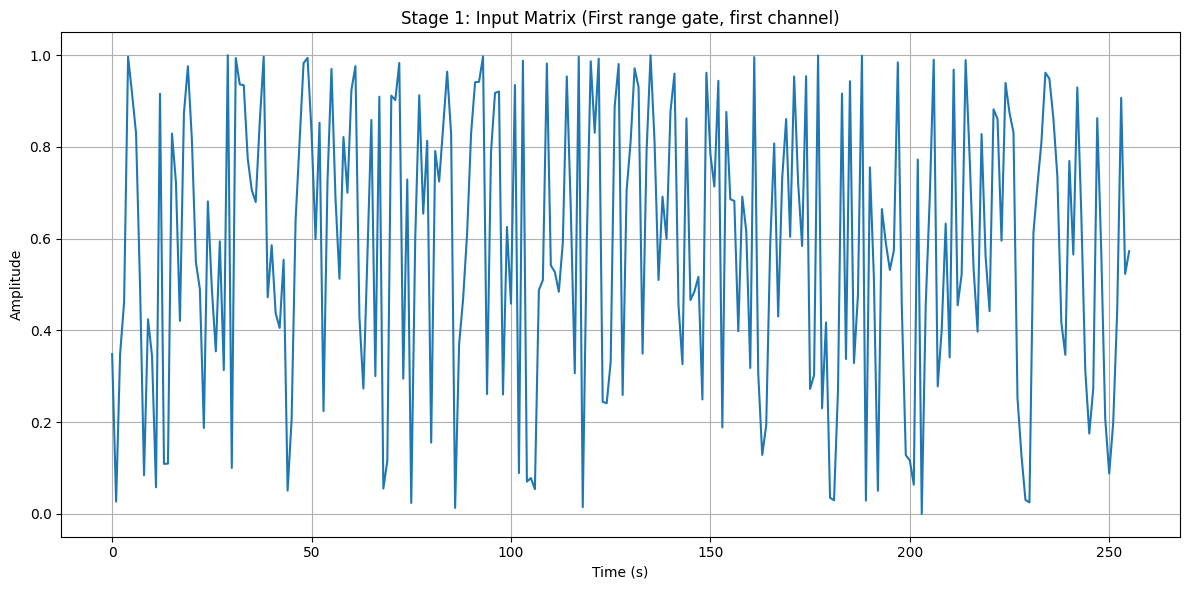

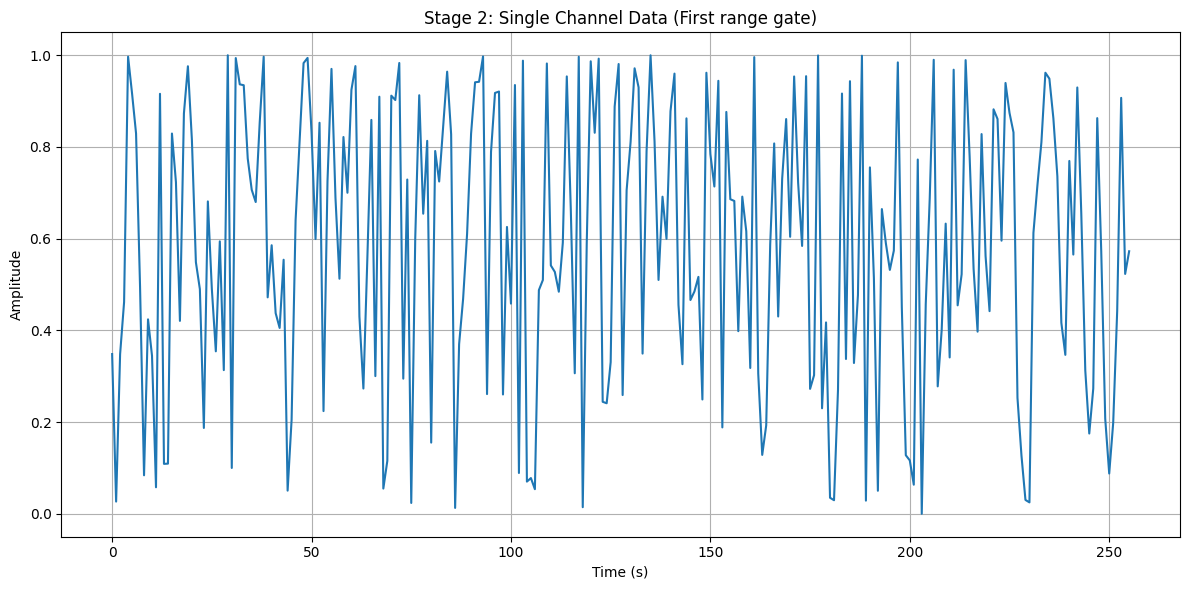

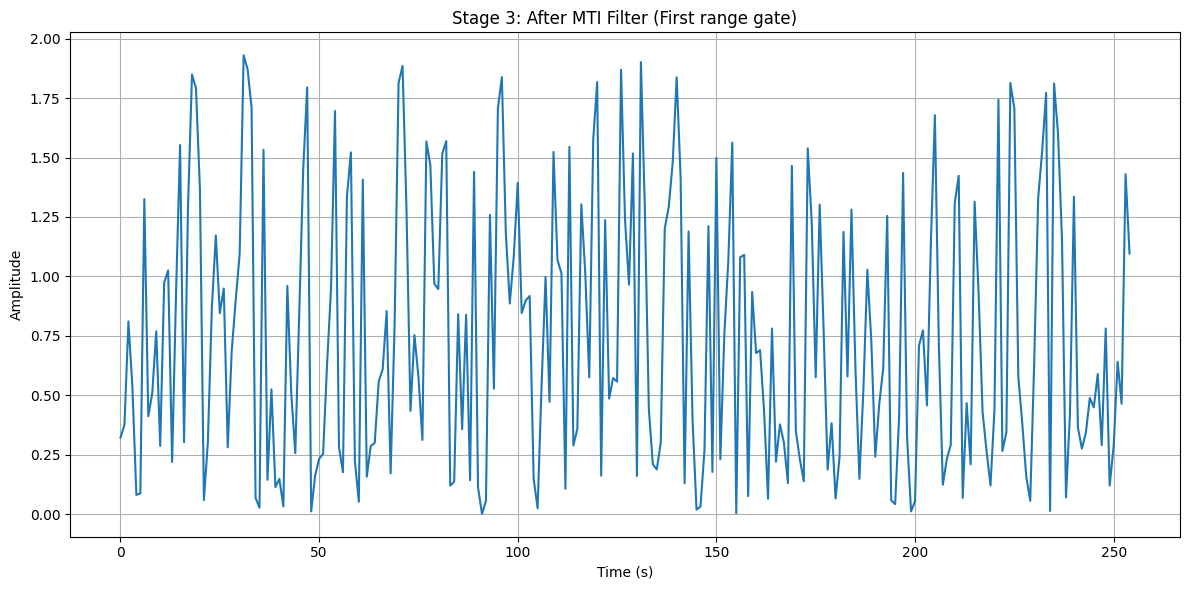

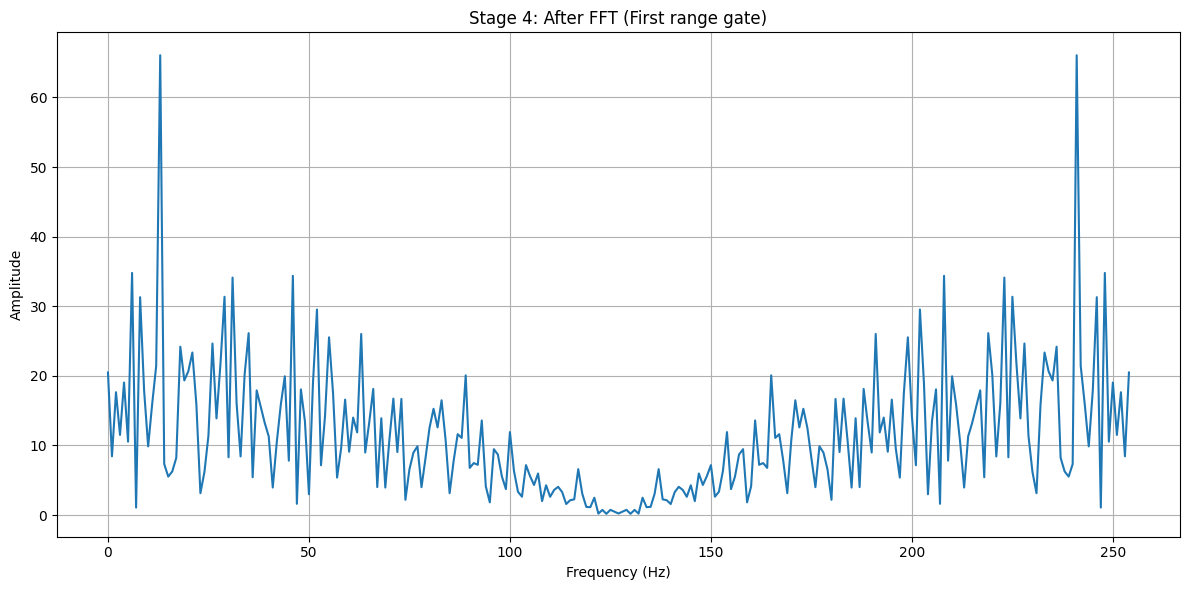

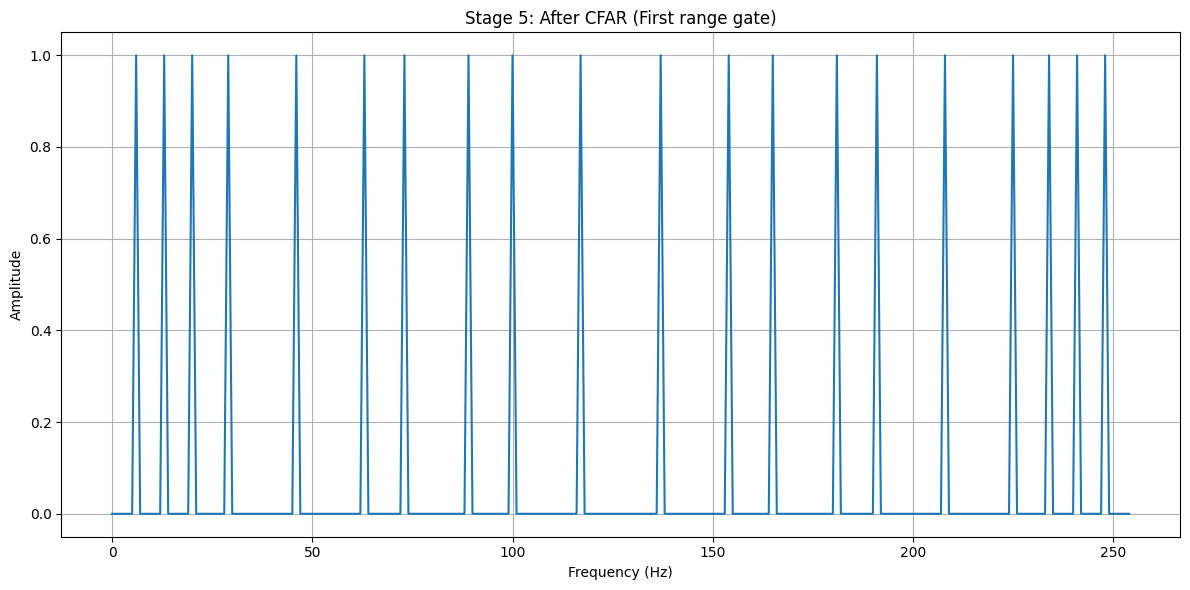

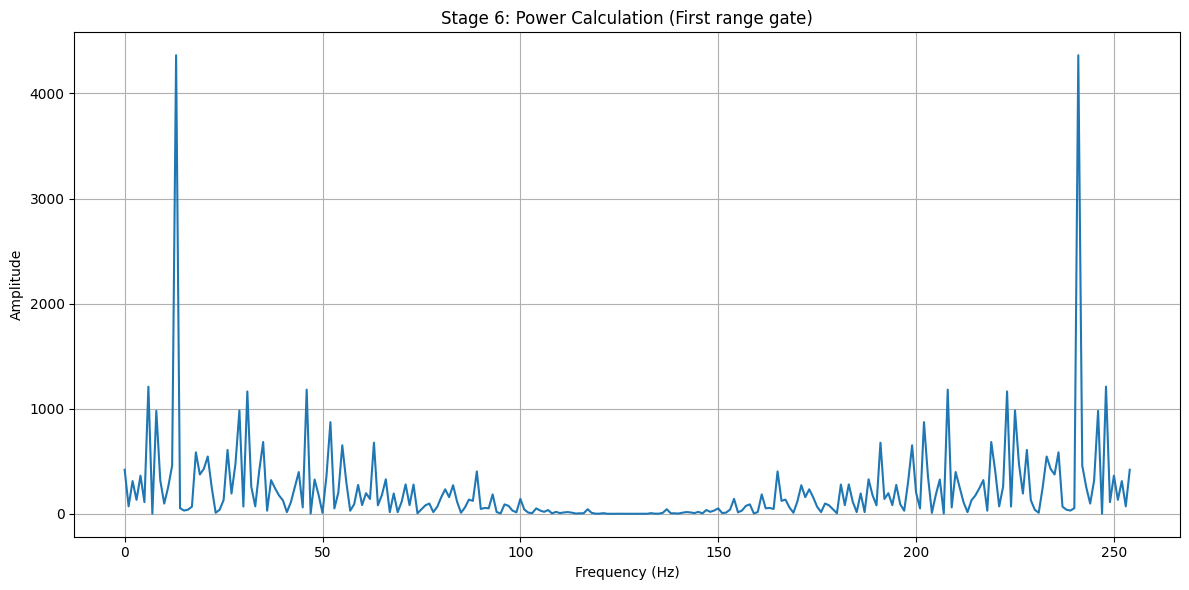

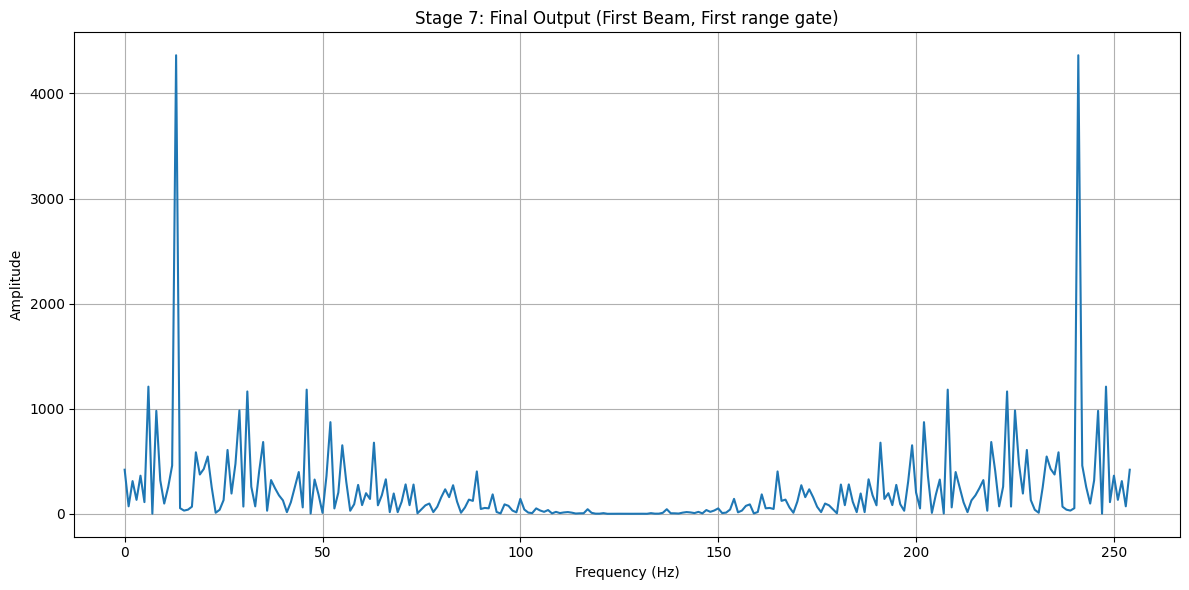

Processing complete. Check the generated plots.


In [ ]:
# Plotting function
def plot_stage(data, title, stage_num, x_label):
    plt.figure(figsize=(12, 6))
    plt.title(f"Stage {stage_num}: {title}")

    if data.ndim == 3:
        # Plot first range gate of first channel for 3D data
        plt.plot(np.abs(data[0,:,0]))
        plt.ylabel('Amplitude')
    elif data.ndim == 2:
        # Plot first range gate
        plt.plot(np.abs(data[0,:]))
        plt.ylabel('Amplitude')

    plt.xlabel(x_label)
    plt.grid(True)
    plt.tight_layout()
    plt.show()

# Main processing pipeline
def radar_processing_pipeline():
    # Stage 1: Input matrix
    input_data = simulate_radar_data()
    plot_stage(input_data, "Input Matrix (First range gate, first channel)", 1, "Time (s)")

    # Stage 2: Separate channels
    # For simplicity, we'll just use the first channel
    channel_data = input_data[:,:,0]
    plot_stage(channel_data, "Single Channel Data (First range gate)", 2, "Time (s)")

    # Stage 3: 2D MTI algorithm
    mti_data = mti_filter(channel_data)
    plot_stage(mti_data, "After MTI Filter (First range gate)", 3, "Time (s)")

    # Stage 4: FFT (Doppler processing)
    doppler_data = doppler_processing(mti_data)
    freq_axis = np.linspace(-pulse_repetition_frequency/2, pulse_repetition_frequency/2, num_pri-1)
    plot_stage(doppler_data, "After FFT (First range gate)", 4, "Frequency (Hz)")

    # Stage 5: CFAR
    cfar_data = cfar(np.abs(doppler_data))
    plot_stage(cfar_data, "After CFAR (First range gate)", 5, "Frequency (Hz)")

    # Stage 6: Power calculation
    power_data = calculate_power(doppler_data)
    plot_stage(power_data, "Power Calculation (First range gate)", 6, "Frequency (Hz)")

    # Stage 7: Final output (simulating multiple beams)
    final_output = np.stack([power_data for _ in range(num_beams)], axis=-1)

    # Plot final output (showing first beam, first range gate)
    plot_stage(final_output[:,:,0], "Final Output (First Beam, First range gate)", 7, "Frequency (Hz)")

    print("Processing complete. Check the generated plots.")

# Run the pipeline
radar_processing_pipeline()


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import chirp
from scipy.fftpack import fft, fftshift
from PIL import Image

# Radar parameters
c = 3e8  # Speed of light
f0 = 24e9  # Start frequency (24 GHz)
B = 200e6  # Bandwidth
T = 1e-3  # Chirp duration
fs = 1e6  # Sampling frequency

num_range_gates = 100
num_pri = 256
num_channels = 4
num_beams = 8
pulse_repetition_frequency = 1000  # Hz

# Target parameters
R = 100  # Range (m)
v = 10  # Velocity (m/s)

# Time array
t = np.arange(0, T, 1/fs)

def simulate_radar_data():
    data = np.zeros((num_range_gates, num_pri, num_channels), dtype=complex)
    tx_signal = chirp(t, f0, T, f0 + B, method='linear')
    tau = 2 * R / c  # Time delay
    fd = 2 * v * f0 / c  # Doppler shift
    rx_signal = chirp(t - tau, f0, T, f0 + B, method='linear') * np.exp(1j * 2 * np.pi * fd * t)

    for ch in range(num_channels):
        for pri in range(num_pri):
            random_delay = np.random.normal(0, 1e-6)
            random_doppler = np.random.normal(0, 1)
            rx_signal_with_noise = chirp(t - (tau + random_delay), f0, T, f0 + B, method='linear') * \
                                   np.exp(1j * 2 * np.pi * (fd + random_doppler) * t)
            mixed_signal = tx_signal * rx_signal_with_noise.conj()
            data[:, pri, ch] = mixed_signal[:num_range_gates]

    return data

def mti_filter(data):
    return np.diff(data, axis=1)

def doppler_processing(data):
    return fftshift(fft(data, axis=1), axes=1)

def cfar(data, guard_cells=2, reference_cells=4):
    threshold = np.zeros_like(data)
    for i in range(data.shape[0]):
        for j in range(data.shape[1]):
            start = max(0, j - reference_cells - guard_cells)
            end = min(data.shape[1], j + reference_cells + guard_cells + 1)
            window = np.concatenate((data[i, start:j-guard_cells],
                                      data[i, j+guard_cells+1:end]))
            threshold[i, j] = np.mean(window) * 2
    return data > threshold

def calculate_power(data):
    return np.abs(data)**2

def plot_stage(data, title, frame_idx, x_label):
    plt.figure(figsize=(12, 6))
    plt.title(title)
    if data.ndim == 3:
        plt.plot(np.abs(data[0, :, 0]))
        plt.ylabel('Amplitude')
    elif data.ndim == 2:
        plt.plot(np.abs(data[0, :]))
        plt.ylabel('Amplitude')
    plt.xlabel(x_label)
    plt.grid(True)
    plt.tight_layout()
    frame_path = f"frame_{frame_idx:02d}.png"
    plt.savefig(frame_path)
    plt.close()
    return frame_path

def radar_processing_pipeline():
    frames = []
    input_data = simulate_radar_data()
    frames.append(plot_stage(input_data, "Stage 1: Input Matrix", 1, "Time (s)"))

    channel_data = input_data[:, :, 0]
    frames.append(plot_stage(channel_data, "Stage 2: Single Channel Data", 2, "Time (s)"))

    mti_data = mti_filter(channel_data)
    frames.append(plot_stage(mti_data, "Stage 3: After MTI Filter", 3, "Time (s)"))

    doppler_data = doppler_processing(mti_data)
    freq_axis = np.linspace(-pulse_repetition_frequency / 2, pulse_repetition_frequency / 2, num_pri - 1)
    frames.append(plot_stage(doppler_data, "Stage 4: After FFT", 4, "Frequency (Hz)"))

    cfar_data = cfar(np.abs(doppler_data))
    frames.append(plot_stage(cfar_data, "Stage 5: After CFAR", 5, "Frequency (Hz)"))

    power_data = calculate_power(doppler_data)
    frames.append(plot_stage(power_data, "Stage 6: Power Calculation", 6, "Frequency (Hz)"))

    final_output = np.stack([power_data for _ in range(num_beams)], axis=-1)
    frames.append(plot_stage(final_output[:, :, 0], "Stage 7: Final Output", 7, "Frequency (Hz)"))

    # Create GIF
    images = [Image.open(frame) for frame in frames]
    images[0].save("radar_processing.gif", save_all=True, append_images=images[1:], duration=500, loop=0)
    print("GIF saved as 'radar_processing.gif'. Check the directory!")

# Run the pipeline
radar_processing_pipeline()


GIF saved as 'radar_processing.gif'. Check the directory!


# 2d values for one chanel

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import fftconvolve
from scipy.fftpack import fft, fftshift
from PIL import Image

# 1. Generate a simulated radar signal
np.random.seed(42)  # For reproducibility
signal_length = 1024  # Power of 2 for FFT
signal = np.random.normal(0, 1, signal_length)  # Random noise

# Add moving targets (peaks) with varying velocities
target_positions = [200, 500, 700]
target_amplitudes = [10, 15, 20]
target_velocities = [2, -3, 4]  # Frequency shifts (Doppler effect)

for idx, velocity in enumerate(target_velocities):
    t = np.arange(0, signal_length)  # Time index
    # Calculate the sinusoidal value for each time point in 't'
    sinusoidal_values = target_amplitudes[idx] * np.sin(2 * np.pi * velocity * t / signal_length)
    # Add the corresponding sinusoidal value to the target position in 'signal'
    signal[target_positions[idx]] += sinusoidal_values[target_positions[idx]]

# Save the raw signal frame
plt.figure(figsize=(12, 6))
plt.plot(signal, label="Original Radar Signal", color="blue")
plt.scatter(target_positions, signal[target_positions], color="red", label="True Targets", zorder=5)
plt.xlabel("Cell Index")
plt.ylabel("Signal Strength")
plt.title("Step 1: Raw Radar Signal with True Targets")
plt.legend()
plt.grid()
frame_path = f"frame_01_raw_signal.png"
plt.savefig(frame_path)
frames = [frame_path]
plt.close()

# 2. MTI (Moving Target Indicator) Processing
# Create a high-pass filter kernel for MTI
filter_kernel = np.array([1, -1])  # Simple MTI filter
mti_signal = fftconvolve(signal, filter_kernel, mode='same')

# Save the MTI signal frame
plt.figure(figsize=(12, 6))
plt.plot(mti_signal, label="MTI-Processed Signal", color="green")
plt.xlabel("Cell Index")
plt.ylabel("Signal Strength")
plt.title("Step 2: Moving Target Indicator (MTI) Processed Signal")
plt.legend()
plt.grid()
frame_path = f"frame_02_mti_signal.png"
plt.savefig(frame_path)
frames.append(frame_path)
plt.close()

# 3. FFT for Doppler Processing
fft_result = fftshift(fft(mti_signal))  # Apply FFT and shift zero frequency to the center
fft_magnitude = np.abs(fft_result)

# Save the FFT frame
plt.figure(figsize=(12, 6))
plt.plot(fft_magnitude, label="FFT Magnitude (Doppler Spectrum)", color="purple")
plt.xlabel("Frequency Index")
plt.ylabel("Magnitude")
plt.title("Step 3: FFT for Doppler Processing")
plt.legend()
plt.grid()
frame_path = f"frame_03_fft_doppler.png"
plt.savefig(frame_path)
frames.append(frame_path)
plt.close()

# 4. CFAR Processing
num_guard_cells = 2
num_reference_cells = 10
threshold_factor = 4

detections = np.zeros(signal_length)
thresholds = np.zeros(signal_length)
noise_levels = np.zeros(signal_length)

for i in range(num_reference_cells + num_guard_cells, signal_length - num_reference_cells - num_guard_cells):
    # Extract reference cells
    reference_cells_left = fft_magnitude[i - num_reference_cells - num_guard_cells:i - num_guard_cells]
    reference_cells_right = fft_magnitude[i + num_guard_cells + 1:i + num_guard_cells + 1 + num_reference_cells]
    reference_cells = np.concatenate((reference_cells_left, reference_cells_right))

    # Calculate noise level and threshold
    noise_level = np.mean(reference_cells)
    threshold = threshold_factor * noise_level

    thresholds[i] = threshold
    noise_levels[i] = noise_level

    # Compare test cell with threshold
    if fft_magnitude[i] > threshold:
        detections[i] = 1

# Save the CFAR result frame
plt.figure(figsize=(12, 6))
plt.plot(fft_magnitude, label="FFT Magnitude (Doppler Spectrum)", color="purple")
plt.plot(thresholds, label="CFAR Threshold", color="orange", linestyle="--")
plt.scatter(np.where(detections == 1), fft_magnitude[detections == 1], color="red", label="Detections")
plt.xlabel("Frequency Index")
plt.ylabel("Magnitude")
plt.title("Step 4: CFAR Detection Results")
plt.legend()
plt.grid()
frame_path = f"frame_04_cfar_detections.png"
plt.savefig(frame_path)
frames.append(frame_path)
plt.close()

# Combine all frames into a GIF
images = [Image.open(frame) for frame in frames]
images[0].save("radar_processing_pipeline.gif", save_all=True, append_images=images[1:], duration=2000, loop=0)

print("GIF saved as 'radar_processing_pipeline.gif'. Check your directory!")


GIF saved as 'radar_processing_pipeline.gif'. Check your directory!


# heat map of the values

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import fftconvolve
from scipy.fftpack import fft, fftshift
from mpl_toolkits.mplot3d import Axes3D
from PIL import Image

# Parameters
np.random.seed(42)
signal_length = 1024
num_pri = 64  # Number of PRIs (Pulse Repetition Intervals)
num_channels = 3  # Number of channels
num_range_bins = signal_length

# 1. Generate 3D Input Matrix (Range Gate, PRI, Channel)
input_matrix = np.random.normal(0, 1, (num_range_bins, num_pri, num_channels))  # Noise
target_positions = [(200, 20), (500, 40), (700, 60)]  # (Range Gate, PRI)
target_amplitudes = [10, 15, 20]
target_velocities = [2, -3, 4]  # Doppler shifts

for idx, (rg, pri) in enumerate(target_positions):
    sinusoidal = target_amplitudes[idx] * np.sin(2 * np.pi * target_velocities[idx] * np.arange(num_pri) / num_pri)
    input_matrix[rg, :, idx] += sinusoidal

# Save the input matrix heatmap
frames = []
for ch in range(num_channels):
    plt.figure(figsize=(12, 6))
    plt.imshow(input_matrix[:, :, ch], aspect='auto', cmap='viridis', extent=[0, num_pri, 0, num_range_bins])
    plt.colorbar(label="Amplitude")
    plt.title(f"Step 1: Input Matrix (Channel {ch + 1})")
    plt.xlabel("PRI")
    plt.ylabel("Range Gate")
    frame_path = f"frame_input_channel_{ch + 1}.png"
    plt.savefig(frame_path)
    frames.append(frame_path)
    plt.close()

# 2. Separate Channels (2D Heatmaps for Each Channel) - Already visualized

# 3. 2D MTI Algorithm
mti_matrix = np.zeros_like(input_matrix)
filter_kernel = np.array([1, -1])  # Simple high-pass filter

for ch in range(num_channels):
    for rg in range(num_range_bins):
        mti_matrix[rg, :, ch] = fftconvolve(input_matrix[rg, :, ch], filter_kernel, mode='same')

# Save the MTI-processed heatmap
for ch in range(num_channels):
    plt.figure(figsize=(12, 6))
    plt.imshow(mti_matrix[:, :, ch], aspect='auto', cmap='plasma', extent=[0, num_pri, 0, num_range_bins])
    plt.colorbar(label="Amplitude")
    plt.title(f"Step 2: MTI Processed Signal (Channel {ch + 1})")
    plt.xlabel("PRI")
    plt.ylabel("Range Gate")
    frame_path = f"frame_mti_channel_{ch + 1}.png"
    plt.savefig(frame_path)
    frames.append(frame_path)
    plt.close()

# 4. FFT (Range-Doppler Map)
fft_matrix = np.zeros_like(mti_matrix, dtype=np.complex128)
for ch in range(num_channels):
    for rg in range(num_range_bins):
        fft_matrix[rg, :, ch] = fftshift(fft(mti_matrix[rg, :, ch]))

fft_magnitude = np.abs(fft_matrix)

# Save the FFT Range-Doppler map
for ch in range(num_channels):
    plt.figure(figsize=(12, 6))
    plt.imshow(fft_magnitude[:, :, ch], aspect='auto', cmap='inferno', extent=[-num_pri // 2, num_pri // 2, 0, num_range_bins])
    plt.colorbar(label="Magnitude")
    plt.title(f"Step 3: FFT (Range-Doppler Map, Channel {ch + 1})")
    plt.xlabel("Doppler Frequency")
    plt.ylabel("Range Gate")
    frame_path = f"frame_fft_channel_{ch + 1}.png"
    plt.savefig(frame_path)
    frames.append(frame_path)
    plt.close()

# 5. CFAR
cfar_matrix = np.zeros_like(fft_magnitude)
threshold_factor = 4
num_guard_cells = 2
num_reference_cells = 10

for ch in range(num_channels):
    for rg in range(num_range_bins):
        for i in range(num_reference_cells + num_guard_cells, num_pri - num_reference_cells - num_guard_cells):
            # Extract reference cells
            ref_cells_left = fft_magnitude[rg, i - num_reference_cells - num_guard_cells:i - num_guard_cells, ch]
            ref_cells_right = fft_magnitude[rg, i + num_guard_cells + 1:i + num_guard_cells + 1 + num_reference_cells, ch]
            ref_cells = np.concatenate((ref_cells_left, ref_cells_right))

            # Calculate threshold
            noise_level = np.mean(ref_cells)
            threshold = threshold_factor * noise_level

            # Compare cell under test
            if fft_magnitude[rg, i, ch] > threshold:
                cfar_matrix[rg, i, ch] = 1

# Save CFAR detection heatmap
for ch in range(num_channels):
    plt.figure(figsize=(12, 6))
    plt.imshow(cfar_matrix[:, :, ch], aspect='auto', cmap='gray', extent=[-num_pri // 2, num_pri // 2, 0, num_range_bins])
    plt.title(f"Step 4: CFAR Detection (Channel {ch + 1})")
    plt.xlabel("Doppler Frequency")
    plt.ylabel("Range Gate")
    frame_path = f"frame_cfar_channel_{ch + 1}.png"
    plt.savefig(frame_path)
    frames.append(frame_path)
    plt.close()

# 6. Final Output (3D Representation)
fig = plt.figure(figsize=(12, 6))
ax = fig.add_subplot(111, projection='3d')
for rg in range(0, num_range_bins, 50):  # Sparse plotting for clarity
    ax.plot(np.arange(-num_pri // 2, num_pri // 2), [rg] * num_pri, fft_magnitude[rg, :, 0], label=f"Range {rg}")
ax.set_xlabel("Doppler Frequency")
ax.set_ylabel("Range Gate")
ax.set_zlabel("Amplitude")
plt.title("Step 5: Final 3D Output (Channel 1)")
frame_path = "frame_final_output.png"
plt.savefig(frame_path)
frames.append(frame_path)
plt.close()

# Create GIF
images = [Image.open(frame) for frame in frames]
images[0].save("radar_pipeline_final.gif", save_all=True, append_images=images[1:], duration=2000, loop=0)

print("GIF saved as 'radar_pipeline_final.gif'. Check your directory!")


GIF saved as 'radar_pipeline_final.gif'. Check your directory!


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import chirp, fftconvolve
from scipy.fftpack import fft, fftshift
from mpl_toolkits.mplot3d import Axes3D
from PIL import Image

# Radar parameters
c = 3e8  # Speed of light
f0 = 24e9  # Start frequency (24 GHz)
B = 200e6  # Bandwidth
T = 1e-3  # Chirp duration
fs = 1e6  # Sampling frequency
num_range_gates = 100
num_pri = 256
num_channels = 4
pulse_repetition_frequency = 1000  # Hz

# Target parameters
R = 100  # Range (m)
v = 10  # Velocity (m/s)

# Time array for a single chirp
t = np.arange(0, T, 1/fs)
range_bins = np.linspace(0, c * T / (2 * B), num_range_gates)

# Step 1: Generate a 3D Input Matrix (Range, PRI, Channel)
input_matrix = np.zeros((num_range_gates, num_pri, num_channels))
target_doppler_shift = 2 * v * f0 / c  # Doppler shift in Hz

#for ch in range(num_channels):
for pri in range(num_pri):
    # Add a chirp for each range gate with Doppler shift
    for rg in range(num_range_gates):
        delay = 2 * R / c  # Round-trip time
        chirp_signal = chirp(t - delay, f0=f0, f1=f0 + B, t1=T, method='linear') * np.cos(2 * np.pi * target_doppler_shift * pri / pulse_repetition_frequency)
        input_matrix[rg, pri, ch] = np.sum(chirp_signal)  # Aggregate signal over chirp

# Visualize the 3D input matrix
fig = plt.figure(figsize=(12, 6))
ax = fig.add_subplot(111, projection='3d')
X, Y = np.meshgrid(range(num_pri), range(num_range_gates))
for ch in range(num_channels):
    ax.plot_surface(X, Y, input_matrix[:, :, ch], cmap='viridis', edgecolor='none')
ax.set_title("Step 1: 3D Input Matrix (All Channels)")
ax.set_xlabel("PRI")
ax.set_ylabel("Range Gate")
ax.set_zlabel("Amplitude")
frame_path = "frame_01_input_matrix.png"
plt.savefig(frame_path)
frames = [frame_path]
plt.close()

# Step 2: MTI (Moving Target Indicator) Processing
mti_matrix = np.zeros_like(input_matrix)
filter_kernel = np.array([1, -1])  # Simple MTI filter

#for ch in range(num_channels):
for rg in range(num_range_gates):
    mti_matrix[rg, :, ch] = fftconvolve(input_matrix[rg, :, ch], filter_kernel, mode='same')

# Save MTI results as line graphs for all channels
#for ch in range(num_channels):
plt.figure(figsize=(12, 6))
for rg in range(0, num_range_gates, 10):  # Plot every 10th range gate
    plt.plot(mti_matrix[rg, :, ch], label=f"Range Gate {rg}")
plt.title(f"Step 2: MTI Processed Signal (Channel {ch + 1})")
plt.xlabel("PRI")
plt.ylabel("Amplitude")
plt.legend()
frame_path = f"frame_02_mti_channel_{ch + 1}.png"
plt.savefig(frame_path)
frames.append(frame_path)
plt.close()

# Step 3: FFT (Range-Doppler Map)
fft_matrix = np.zeros_like(mti_matrix, dtype=np.complex128)
#for ch in range(num_channels):
for rg in range(num_range_gates):
    fft_matrix[rg, :, ch] = fftshift(fft(mti_matrix[rg, :, ch]))

fft_magnitude = np.abs(fft_matrix)

# Save FFT results as line graphs for all channels
#for ch in range(num_channels):
plt.figure(figsize=(12, 6))
for rg in range(0, num_range_gates, 10):  # Plot every 10th range gate
    plt.plot(fft_magnitude[rg, :, ch], label=f"Range Gate {rg}")
plt.title(f"Step 3: FFT (Range-Doppler Map, Channel {ch + 1})")
plt.xlabel("Doppler Frequency Index")
plt.ylabel("Magnitude")
plt.legend()
frame_path = f"frame_03_fft_channel_{ch + 1}.png"
plt.savefig(frame_path)
frames.append(frame_path)
plt.close()

# Step 4: CFAR (Constant False Alarm Rate)
cfar_matrix = np.zeros_like(fft_magnitude)
threshold_factor = 4
num_guard_cells = 2
num_reference_cells = 10

#for ch in range(num_channels):
for rg in range(num_range_gates):
    for i in range(num_reference_cells + num_guard_cells, num_pri - num_reference_cells - num_guard_cells):
        # Extract reference cells
        ref_cells_left = fft_magnitude[rg, i - num_reference_cells - num_guard_cells:i - num_guard_cells, ch]
        ref_cells_right = fft_magnitude[rg, i + num_guard_cells + 1:i + num_guard_cells + 1 + num_reference_cells, ch]
        ref_cells = np.concatenate((ref_cells_left, ref_cells_right))

        # Calculate threshold
        noise_level = np.mean(ref_cells)
        threshold = threshold_factor * noise_level

        # Compare cell under test
        if fft_magnitude[rg, i, ch] > threshold:
            cfar_matrix[rg, i, ch] = 1

# Save CFAR results as line graphs for all channels
#for ch in range(num_channels):
plt.figure(figsize=(12, 6))
for rg in range(0, num_range_gates, 10):  # Plot every 10th range gate
    plt.plot(cfar_matrix[rg, :, ch], label=f"Range Gate {rg}")
plt.title(f"Step 4: CFAR Detection (Channel {ch + 1})")
plt.xlabel("Doppler Frequency Index")
plt.ylabel("Detection")
plt.legend()
frame_path = f"frame_04_cfar_channel_{ch + 1}.png"
plt.savefig(frame_path)
frames.append(frame_path)
plt.close()

# Step 5: Final 3D Output (All Channels)
fig = plt.figure(figsize=(12, 6))
ax = fig.add_subplot(111, projection='3d')
X, Y = np.meshgrid(range(num_pri), range(num_range_gates))
for ch in range(num_channels):
    ax.plot_surface(X, Y, fft_magnitude[:, :, ch], cmap='viridis', edgecolor='none')
ax.set_title("Step 5: Final 3D Output (All Channels)")
ax.set_xlabel("PRI")
ax.set_ylabel("Range Gate")
ax.set_zlabel("Amplitude")
frame_path = "frame_05_final_output.png"
plt.savefig(frame_path)
frames.append(frame_path)
plt.close()

# Create GIF
images = [Image.open(frame) for frame in frames]
images[0].save("radar_pipeline_line_graphs.gif", save_all=True, append_images=images[1:], duration=2000, loop=0)

print("GIF saved as 'radar_pipeline_line_graphs.gif'. Check your directory!")


GIF saved as 'radar_pipeline_line_graphs.gif'. Check your directory!


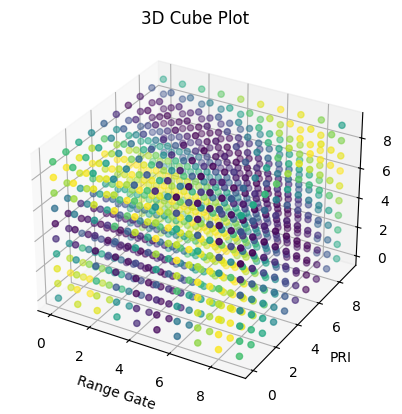

In [ ]:
# prompt: creat a 3D cube that has on the X Range gate on the Y PRI and on the Z Channel

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import numpy as np

# Sample data (replace with your actual data)
x = np.arange(0, 10, 1)
y = np.arange(0, 10, 1)
z = np.arange(0, 10, 1)
X, Y, Z = np.meshgrid(x, y, z)
data = np.sin(np.sqrt(X**2 + Y**2 + Z**2))

# Create a 3D plot
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

# Plot the cube
ax.scatter(X, Y, Z, c=data, cmap='viridis')

# Set labels and title
ax.set_xlabel('Range Gate')
ax.set_ylabel('PRI')
ax.set_zlabel('Channel')
ax.set_title('3D Cube Plot')

# Show the plot
plt.show()

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import imageio

# Simulate radar data: stationary and moving targets
np.random.seed(0)
n_samples = 100
n_points = 50

# Generate stationary targets (constant values)
stationary_data = np.random.normal(loc=0, scale=1, size=(n_samples, n_points))

# Generate moving targets (a sine wave pattern added to simulate movement)
time = np.linspace(0, 4 * np.pi, n_samples)
moving_target = np.sin(time) * 5  # Sinusoidal moving pattern for the target
moving_data = stationary_data.copy()
moving_data[:, 0] += moving_target  # Adding moving signal to the first point

# Set up the GIF writer
gif_filename = "MTI_simulation.gif"
with imageio.get_writer(gif_filename, mode='I', duration=0.2) as writer:

    # Create and save each frame of the GIF
    Y = moving_data.copy()  # Initial data (before filtering)
    for i in range(1, n_samples):
        # MTI filtering: subtract previous step from current (Y[i] = Y[i] - Y[i-1])
        Y[i] = Y[i] - moving_data[i-1]

        # Plotting the graph
        fig, ax = plt.subplots(figsize=(8, 6))

        # Plot original and filtered data
        ax.plot(moving_data[:i+1, 0], label="Original Data", color='blue', alpha=0.6)
        ax.plot(Y[:i+1, 0], label="Filtered Data (MTI)", color='red', linestyle='--')

        # Add labels and title
        ax.set_title(f'MTI Filtering - Step {i}')
        ax.set_xlabel('Samples')
        ax.set_ylabel('Signal Amplitude')
        ax.legend(loc='upper right')

        # Convert plot to image and append to GIF
        plt.tight_layout()
        fig.canvas.draw()  # Ensure the canvas is updated
        image = np.array(fig.canvas.renderer.buffer_rgba())  # Get image from canvas
        writer.append_data(image)

        # Close the figure to avoid memory issues
        plt.close(fig)

print(f"GIF saved as {gif_filename}")


GIF saved as MTI_simulation.gif


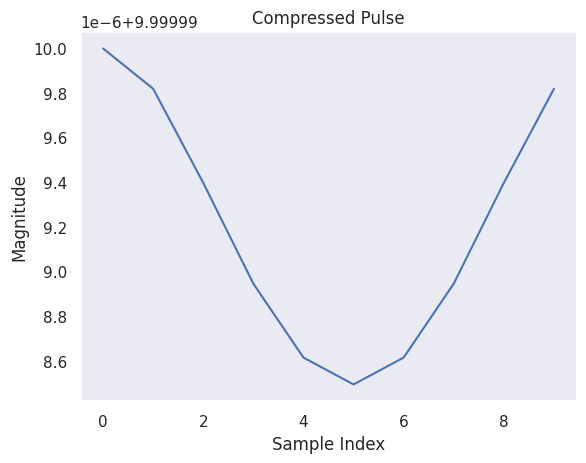

In [19]:
import numpy as np
import matplotlib.pyplot as plt

# Define parameters
fs = 1e6  # Sampling frequency (1 MHz)
T = 10e-6  # Pulse duration (10 µs)
B = 10e6  # Bandwidth (10 MHz)
N = int(fs * T)  # Number of samples
t = np.linspace(-T/2, T/2, N)

# Generate a chirp signal
chirp_signal = np.exp(1j * np.pi * B * t**2)

# Compute FFT of chirp signal
S_f = np.fft.fft(chirp_signal)

# Simulate received signal (assume perfect reflection)
R_f = S_f  # No delay, no noise

# Matched filtering using FFT & IFFT
H_f = np.conj(S_f)  # Conjugate of transmitted signal
Y_f = R_f * H_f  # Multiply in frequency domain
compressed_pulse = np.fft.ifft(Y_f)  # Convert back to time domain

# Plot compressed pulse
plt.figure()
plt.plot(np.abs(compressed_pulse))
plt.title("Compressed Pulse")
plt.xlabel("Sample Index")
plt.ylabel("Magnitude")
plt.grid()
plt.show()


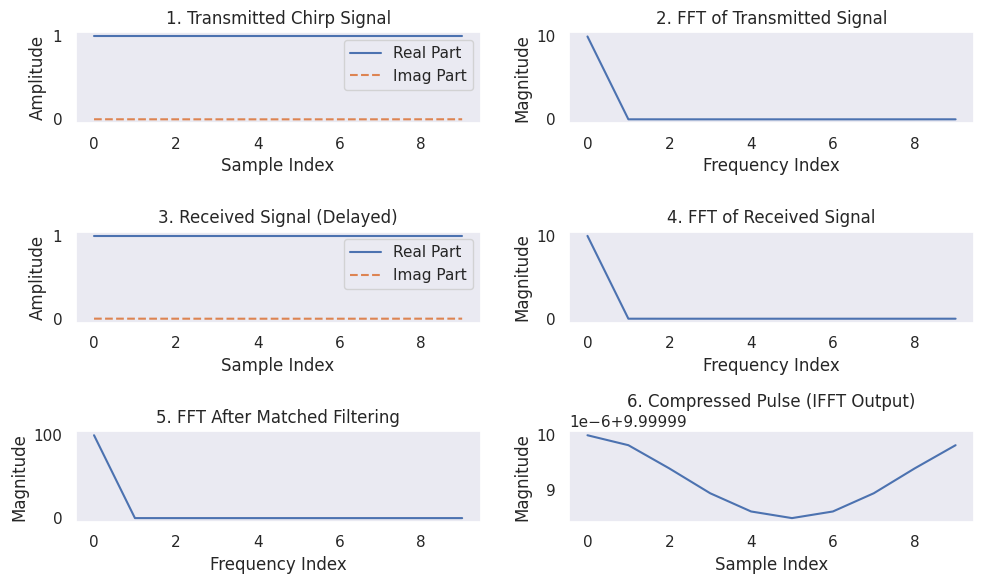

In [21]:
import numpy as np
import matplotlib.pyplot as plt

# Define parameters
fs = 1e6  # Sampling frequency (1 MHz)
T = 10e-6  # Pulse duration (10 µs)
B = 10e6  # Bandwidth (10 MHz)
N = int(fs * T)  # Number of samples
t = np.linspace(-T/2, T/2, N)

# Step 1: Generate a chirp signal (LFM pulse)
chirp_signal = np.exp(1j * np.pi * B * t**2)

# Step 2: Compute FFT of transmitted signal
S_f = np.fft.fft(chirp_signal)

# Step 3: Simulate received signal (introduce delay)
delay_samples = 20
received_signal = np.roll(chirp_signal, delay_samples)

# Compute FFT of received signal
R_f = np.fft.fft(received_signal)

# Step 4: Matched filtering using FFT & IFFT
H_f = np.conj(S_f)  # Conjugate of transmitted signal
Y_f = R_f * H_f  # Multiply in frequency domain

# Step 5: Compute the compressed pulse using IFFT
compressed_pulse = np.fft.ifft(Y_f)

# Step 6: Plot the results
plt.figure(figsize=(10, 6))

plt.subplot(3, 2, 1)
plt.plot(np.real(chirp_signal), label="Real Part")
plt.plot(np.imag(chirp_signal), label="Imag Part", linestyle="dashed")
plt.title("1. Transmitted Chirp Signal")
plt.xlabel("Sample Index")
plt.ylabel("Amplitude")
plt.legend()
plt.grid()

plt.subplot(3, 2, 2)
plt.plot(np.abs(S_f))
plt.title("2. FFT of Transmitted Signal")
plt.xlabel("Frequency Index")
plt.ylabel("Magnitude")
plt.grid()

plt.subplot(3, 2, 3)
plt.plot(np.real(received_signal), label="Real Part")
plt.plot(np.imag(received_signal), label="Imag Part", linestyle="dashed")
plt.title("3. Received Signal (Delayed)")
plt.xlabel("Sample Index")
plt.ylabel("Amplitude")
plt.legend()
plt.grid()

plt.subplot(3, 2, 4)
plt.plot(np.abs(R_f))
plt.title("4. FFT of Received Signal")
plt.xlabel("Frequency Index")
plt.ylabel("Magnitude")
plt.grid()

plt.subplot(3, 2, 5)
plt.plot(np.abs(Y_f))
plt.title("5. FFT After Matched Filtering")
plt.xlabel("Frequency Index")
plt.ylabel("Magnitude")
plt.grid()

plt.subplot(3, 2, 6)
plt.plot(np.abs(compressed_pulse))
plt.title("6. Compressed Pulse (IFFT Output)")
plt.xlabel("Sample Index")
plt.ylabel("Magnitude")
plt.grid()

plt.tight_layout()
plt.show()


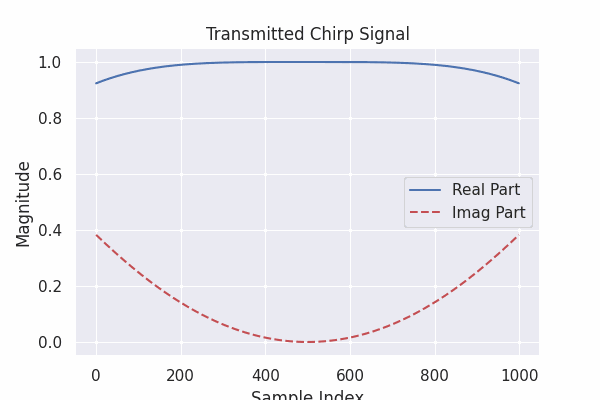

In [36]:
import numpy as np
import matplotlib.pyplot as plt
import imageio
from IPython.display import display, Image

# Define parameters for a longer signal with more peaks in FFT
fs = 1e7  # Sampling frequency (10 MHz) - Increased for higher resolution
T = 100e-6  # Pulse duration (100 µs) - Increased to make the signal longer
B = 50e6  # Bandwidth (50 MHz) - Increased for more frequency variation
N = int(fs * T)  # Number of samples
t = np.linspace(-T/2, T/2, N)

# Step 1: Generate a chirp signal (LFM pulse with more frequency variation)
chirp_signal = np.exp(1j * np.pi * B * t**2)

# Step 2: Compute FFT of transmitted signal
S_f = np.fft.fft(chirp_signal)

# Step 3: Simulate received signal (introduce delay)
delay_samples = 50  # Increased delay for a longer signal
received_signal = np.roll(chirp_signal, delay_samples)

# Compute FFT of received signal
R_f = np.fft.fft(received_signal)

# Step 4: Matched filtering using FFT & IFFT
H_f = np.conj(S_f)  # Conjugate of transmitted signal
Y_f = R_f * H_f  # Multiply in frequency domain

# Step 5: Compute the compressed pulse using IFFT
compressed_pulse = np.fft.ifft(Y_f)

# Create frames for the GIF
frames = []
fig, ax = plt.subplots(figsize=(6, 4))

# Steps to visualize
steps = [chirp_signal, np.abs(S_f), received_signal, np.abs(R_f), np.abs(Y_f), np.abs(compressed_pulse)]
titles = [
    "Transmitted Chirp Signal",
    "FFT of Transmitted Signal",
    "Received Signal (Delayed)",
    "FFT of Received Signal",
    "FFT After Matched Filtering",
    "Compressed Pulse (IFFT Output)"
]

# Generate images for the GIF
for i, data in enumerate(steps):
    ax.clear()
    ax.plot(np.real(data), 'b', label="Real Part")
    if np.iscomplexobj(data):
        ax.plot(np.imag(data), 'r', linestyle="dashed", label="Imag Part")
    ax.set_title(titles[i])
    ax.set_xlabel("Sample Index" if i % 2 == 0 else "Frequency Index")
    ax.set_ylabel("Magnitude")
    ax.legend()
    ax.grid(True)

    # Save frame
    fig.canvas.draw()
    frame = np.array(fig.canvas.renderer.buffer_rgba())
    frames.append(frame)

# Save as GIF in Colab with 1-second duration per frame
gif_path = "dpc_full_process_more_peaks_fft.gif"
imageio.mimsave(gif_path, frames, duration=1000.0)  # <-- 1-second duration per frame

plt.close(fig)

# Display the GIF in Colab
display(Image(filename=gif_path))

# Provide download link
from google.colab import files
# files.download(gif_path)
